In [0]:
import pandas as pd
import numpy as np

wine_data1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ASM/winemag-data-130k-v2.csv')
wine_data2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ASM/winemag-data_first150k.csv')

In [0]:
wine_data = pd.concat([wine_data1, wine_data2])
wine_data.describe()

,Unnamed: 0,points,price
count,280901.000000,280901.000000,258210.000000
mean,70615.705960,88.146934,34.177162
std,41214.379445,3.151528,38.611708
min,0.000000,80.000000,4.000000
25%,35112.000000,86.000000,16.000000
50%,70225.000000,88.000000,25.000000
75%,105337.000000,90.000000,40.000000
max,150929.000000,100.000000,3300.000000


In [0]:
print("Total number of examples: ", wine_data.shape[0])
print("Number of examples with the same title and description: ", wine_data[wine_data.duplicated(['description','title'])].shape[0])

Total number of examples:  280901
Number of examples with the same title and description:  63092


In [0]:
wine_data=wine_data.drop_duplicates(['description','title'])
wine_data= wine_data.reset_index(drop=True)

In [0]:
wine_data=wine_data.drop(columns=['Unnamed: 0'])
wine_data=wine_data.reset_index(drop=True)



In [0]:
wine_data_us = wine_data[wine_data.country =='US']
wine_data_us=wine_data_us.dropna(subset=['price'])
wine_data_us=wine_data_us.reset_index(drop=True)

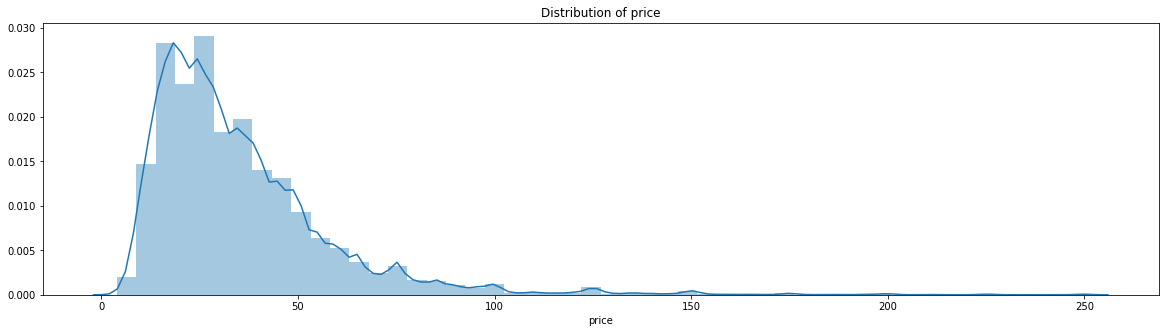

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,5))
plt.title("Distribution of price")
sns.distplot(wine_data_us[wine_data_us['price']<=250]['price'])

In [0]:
!pip install catboost

     |████████████████████████████████| 64.4MB 50kB/s 


In [0]:
wine_data_us.corr()

,points,price
points,1.000000,0.454964
price,0.454964,1.000000


# **Q 2. Let's build linear regression model for wines from USA. We shall be doing data pre-processing steps and then building simple linear regression model.**

---



---



---



*   List item

---



> Indented block


*   List item





In [0]:
### Lets build a linear regression model on US dataset.
#### Lets pick dataset specific to US and store it in wine_us_data dataframe.
wine_us_data = wine_data[wine_data.country == 'US']

## Lets analyse NULL data available in each column
wine_us_missing = pd.DataFrame(wine_us_data.isnull().sum()/len(wine_us_data.index) * 100)
wine_us_missing.columns = ['percent']
wine_us_missing


,percent
Unnamed: 0,0.000000
country,0.000000
description,0.000000
designation,33.623115
points,0.000000
price,0.452807
province,0.000000
region_1,0.401152
region_2,5.210577
taster_name,62.120280


In [0]:
## As given above, few columns such as taster_name, taster_twitter_handle and title have more than 40 percent values to be Null. I will be getting rid of these columns and will do analysis on other columns.

wine_us_data.drop(['taster_twitter_handle','taster_name','Unnamed: 0','country'], inplace = True, axis = 1, errors = 'ignore')

## For categorical columns, such as designation, region_1, region_2, Null values are replaced with Unknown column values.
wine_us_data['designation'].fillna('Unknown', inplace = True)
wine_us_data['region_1'].fillna('Unknown', inplace = True)
wine_us_data['region_2'].fillna('Unknown', inplace = True)

# For integer column price, null values are filled with mean values
wine_us_data['price'].fillna((wine_us_data['price'].mean()), inplace = True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [0]:
### since we need to do encoding for categorical columns, we need to install below module in python.
!pip install category_encoders

     |████████████████████████████████| 102kB 2.8MB/s 


In [0]:
### Below encoding method is based on number of specfic classes in categorical data specific to target variable 'points'. Below encoding is called Count Encoder in which counting of specific classes are calculated and replaced
## in category classes. I did use other type of encoding such as target encoding and hash encoding technique but thses technique will tend to overfit the model. Hence I have used simple encoding technique.

from category_encoders import CountEncoder

y = wine_us_data['points'].values
X = pd.DataFrame(wine_us_data, columns=wine_us_data.columns)
enc = CountEncoder(cols=['designation', 'winery', 'province', 'region_1', 'variety','region_2','title']).fit(X, y)

# Data is transformed into numerical fields
numeric_dataset = enc.transform(X)
numeric_dataset.head(4)

/usr/local/lib/python3.6/dist-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


,description,designation,points,price,province,region_1,region_2,title,variety,winery
2,"Tart and snappy, the flavors of lime flesh and...",30593,87,14.0,7798,3387,5121,1,1349,19
3,"Pineapple rind, lemon pith and orange blossom ...",11,87,13.0,124,29,4741,1,2690,10
4,"Much like the regular bottling from 2012, this...",1,87,65.0,7798,3387,5121,1,15847,24
10,"Soft, supple plum envelopes an oaky structure ...",22,87,19.0,62447,8302,12235,1,12866,95


In [0]:
## Getting rid of description and points(target column) to run the model
numeric_dataset.drop(['description','points'], inplace = True, axis = 1, errors = 'ignore')

In [0]:
### Sourcing packages and modules required to run linear regression model

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Create linear regression object

y = wine_us_data['points'].values

### dividing dataset into training and testing split(70, 30)
X_train, X_test, y_train, y_test = train_test_split(numeric_dataset, y, test_size = 0.30, random_state = 12)

# train the model
lm = linear_model.LinearRegression()

## fiting linear regression model
lm.fit(X_train,y_train)

##predict the model
y_pred = lm.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 2.2822332262338745
Root Mean Squared Error: 2.806260242987981


# Interpretation of model accuracy

 The idea is to reduce mean absolute error or root mean squared error when building linear regression model. Hence I have started with 2 columns at a time and then compared the results. After that, I have got best accuracy as given above using features designation, price, variety, winery, region_1, region_2, title

# Feature selection based on Statistical model as given below

In [0]:
from statsmodels.api import OLS
from IPython.display import display

display(OLS(y, numeric_dataset['designation']).fit().summary())
display(OLS(y, numeric_dataset['winery']).fit().summary())
display(OLS(y, numeric_dataset['variety']).fit().summary())
display(OLS(y, numeric_dataset['price']).fit().summary())
display(OLS(y, numeric_dataset['region_1']).fit().summary())
display(OLS(y, numeric_dataset['region_2']).fit().summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.338
Model:                            OLS   Adj. R-squared (uncentered):              0.338
Method:                 Least Squares   F-statistic:                          4.639e+04
Date:                Tue, 21 Apr 2020   Prob (F-statistic):                        0.00
Time:                        10:54:40   Log-Likelihood:                     -5.1809e+05
No. Observations:               90988   AIC:                                  1.036e+06
Df Residuals:                   90987   BIC:                                  1.036e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
designation     0.0029   1.34e-05    215.379      0.000       0.003       0.003
==============================================================================
Omnibus:                   546940.566   Durbin-Watson:                   0.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15621.107
Skew:                          -0.682   Prob(JB):                         0.00
Kurtosis:                       1.496   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.485
Model:                            OLS   Adj. R-squared (uncentered):              0.485
Method:                 Least Squares   F-statistic:                          8.574e+04
Date:                Tue, 21 Apr 2020   Prob (F-statistic):                        0.00
Time:                        10:54:40   Log-Likelihood:                     -5.0663e+05
No. Observations:               90988   AIC:                                  1.013e+06
Df Residuals:                   90987   BIC:                                  1.013e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
winery         0.7152      0.002    292.812      0.000       0.710       0.720
==============================================================================
Omnibus:                    49481.008   Durbin-Watson:                   0.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           437069.224
Skew:                          -2.499   Prob(JB):                         0.00
Kurtosis:                      12.503   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.650
Model:                            OLS   Adj. R-squared (uncentered):              0.650
Method:                 Least Squares   F-statistic:                          1.689e+05
Date:                Tue, 21 Apr 2020   Prob (F-statistic):                        0.00
Time:                        10:54:40   Log-Likelihood:                     -4.8909e+05
No. Observations:               90988   AIC:                                  9.782e+05
Df Residuals:                   90987   BIC:                                  9.782e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
variety        0.0075   1.82e-05    410.920      0.000       0.007       0.008
==============================================================================
Omnibus:                   518361.260   Durbin-Watson:                   1.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9219.439
Skew:                          -0.170   Prob(JB):                         0.00
Kurtosis:                       1.478   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.653
Model:                            OLS   Adj. R-squared (uncentered):              0.653
Method:                 Least Squares   F-statistic:                          1.709e+05
Date:                Tue, 21 Apr 2020   Prob (F-statistic):                        0.00
Time:                        10:54:41   Log-Likelihood:                     -4.8874e+05
No. Observations:               90988   AIC:                                  9.775e+05
Df Residuals:                   90987   BIC:                                  9.775e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
price          1.6019      0.004    413.349      0.000       1.594       1.610
==============================================================================
Omnibus:                   169960.923   Durbin-Watson:                   1.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2285535349.173
Skew:                         -13.322   Prob(JB):                         0.00
Kurtosis:                     778.982   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.533
Model:                            OLS   Adj. R-squared (uncentered):              0.533
Method:                 Least Squares   F-statistic:                          1.037e+05
Date:                Tue, 21 Apr 2020   Prob (F-statistic):                        0.00
Time:                        10:54:41   Log-Likelihood:                     -5.0222e+05
No. Observations:               90988   AIC:                                  1.004e+06
Df Residuals:                   90987   BIC:                                  1.004e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
region_1       0.0166   5.15e-05    322.017      0.000       0.016       0.017
==============================================================================
Omnibus:                    11465.211   Durbin-Watson:                   1.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12954.226
Skew:                          -0.878   Prob(JB):                         0.00
Kurtosis:                       2.421   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.772
Model:                            OLS   Adj. R-squared (uncentered):              0.772
Method:                 Least Squares   F-statistic:                          3.074e+05
Date:                Tue, 21 Apr 2020   Prob (F-statistic):                        0.00
Time:                        10:54:41   Log-Likelihood:                     -4.6965e+05
No. Observations:               90988   AIC:                                  9.393e+05
Df Residuals:                   90987   BIC:                                  9.393e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
region_2       0.0061   1.09e-05    554.462      0.000       0.006       0.006
==============================================================================
Omnibus:                   279319.534   Durbin-Watson:                   1.408
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8690.545
Skew:                           0.396   Prob(JB):                         0.00
Kurtosis:                       1.710   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Most important features:
As clearly visible in above reports. R-squared values for columns such as designation, region_1, winery is below 60 percent and for columns such as price, variety, region_2 is above 60 percent. We can deduce that these 3 columns Price, Variery, Region_2 are most important factors to decide wine rating or variation in ratings of US wines can be explained by these columns together.

In [0]:
## Removing lower case, removing punctuation, removing numbers , then removing stop words in english and then I have applied lemmatization.


import nltk
import nltk
nltk.download("popular")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

wine_us_desc = pd.DataFrame({'description': wine_us_data['description']})
wine_us_desc['desc_col'] = wine_us_desc['description'].apply(lambda x: x.lower())
wine_us_desc['desc_col'] = wine_us_desc['desc_col'].str.replace('[^\w\s]', '')
wine_us_desc['desc_col'] = wine_us_desc['desc_col'].str.replace('[0-9]+', '')

stop_words = stopwords.words('english')
wine_us_desc['desc_col'] = wine_us_desc['desc_col'].apply(lambda x: ' '.join(w for w in x.split() if w not in stop_words))

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

def get_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize(sentence):
    tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    lemmatized_sentence = []
    for word, tag in tagged:
        wntag = get_wordnet_tag(tag)
        if wntag is None:
            lemmatized_sentence.append(lemmatizer.lemmatize(word))
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, pos = wntag))
    return ' '.join(lemmatized_sentence)

wine_us_desc['desc_col'] = wine_us_desc['desc_col'].apply(lambda x: lemmatize(x))
wine_us_desc['desc_col'][:10]



[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

2     tart snappy flavor lime flesh rind dominate gr...
3     pineapple rind lemon pith orange blossom start...
4     much like regular bottle come across rather ro...
10    soft supple plum envelop oaky structure cabern...
12    slightly reduce wine offer chalky tannic backb...
14    building year six generation winemaking tradit...
19    red fruit aroma pervade nose cigar box menthol...
20    ripe aroma dark berry mingle ample note black ...
21    sleek mix tart berry stem herb along hint oak ...
23    wine geneseo district offer aromas sour plum e...
Name: desc_col, dtype: object

In [0]:
pd.Series(' '.join(wine_us_desc['desc_col']).split()).value_counts()[:10]

flavor     59078
wine       49635
fruit      33831
cherry     28441
finish     23382
dry        21254
acidity    18237
oak        17576
tannin     16799
black      16238
dtype: int64

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features = 500)
tfidf_vectorizer.fit(wine_us_desc['desc_col'] )
X_tfidf_us = tfidf_vectorizer.transform(wine_us_desc['desc_col'] )


In [0]:
x_tf = pd.DataFrame(X_tfidf_us.toarray())
x_tf.shape

(90988, 500)

In [0]:
terms = tfidf_vectorizer.get_feature_names()
sums = X_tfidf_us.sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])
print(ranking.sort_values('rank', ascending=False))

           term         rank
344      flavor  4748.918829
971        wine  4405.932136
367       fruit  3573.837172
158      cherry  3325.937861
338      finish  2893.751985
..          ...          ...
149       chalk    95.920893
930        upon    95.739822
918  tremendous    95.536048
108     breathe    95.400827
749   sagebrush    94.507408

[1000 rows x 2 columns]


In [0]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Create linear regression object


x_final  = pd.concat([numeric_dataset.reset_index(drop=True), x_tf], axis=1)
#x_final  = pd.concat([X_final_US.reset_index(drop=True), x_tf], axis=1)
y = wine_us_data['points'].values
X_train, X_test, y_train, y_test = train_test_split(x_final, y, test_size = 0.30, random_state = 12)

# train the model
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)

##predict the model
y_pred = lm.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.488605778112927
Root Mean Squared Error: 1.887167346227234


In [0]:
from statsmodels.api import OLS
OLS(y,x_final).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          1.708e+04
Date:                Mon, 20 Apr 2020   Prob (F-statistic):                        0.00
Time:                        11:06:24   Log-Likelihood:                     -3.2884e+05
No. Observations:               90988   AIC:                                  6.587e+05
Df Residuals:                   90481   BIC:                                  6.635e+05
Df Model:                         507                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
designation  7.587e-05   2.21e-06     34.336      0.000    7.15e-05    8.02e-05
price           0.0408      0.001     30.090      0.000       0.038       0.043
province        0.0001   1.91e-06     75.236      0.000       0.000       0.000
region_1        0.0003    1.2e-05     25.223      0.000       0.000       0.000
region_2        0.0001   5.91e-06     24.867      0.000       0.000       0.000
variety         0.0003   6.84e-06     45.385      0.000       0.000       0.000
winery          0.0117      0.001     23.198      0.000       0.011       0.013
0              13.8285      0.668     20.692      0.000      12.519      15.138
1              21.9441      0.610     35.945      0.000      20.748      23.141
2              23.4923      0.749     31.358      0.000      22.024      24.961
3              19.5244      0.533     36.623      0.000      18.479      20.569
4              15.2563      1.023     14.911      0.000      13.251      17.262
5              10.2272      0.661     15.480      0.000       8.932      11.522
6              15.0984      0.596     25.322      0.000      13.930      16.267
7              21.5098      0.666     32.312      0.000      20.205      22.815
8              13.6003      0.621     21.899      0.000      12.383      14.818
9              14.2337      0.696     20.438      0.000      12.869      15.599
10             10.7876      0.628     17.170      0.000       9.556      12.019
11              9.5445      0.747     12.772      0.000       8.080      11.009
12             15.5939      1.065     14.639      0.000      13.506      17.682
13             11.8305      0.737     16.052      0.000      10.386      13.275
14             15.7214      0.992     15.843      0.000      13.776      17.666
15             19.5800      0.663     29.543      0.000      18.281      20.879
16             10.9522      0.856     12.796      0.000       9.275      12.630
17             21.3092      0.540     39.477      0.000      20.251      22.367
18             21.5703      0.661     32.616      0.000      20.274      22.867
19             25.0317      0.539     46.419      0.000      23.975      26.089
20             24.3431      0.576     42.272      0.000      23.214      25.472
21             24.9692      0.863     28.938      0.000      23.278      26.660
22             15.2428      0.787     19.379      0.000      13.701      16.784
23              7.3421      0.941      7.805      0.000       5.498       9.186
24             19.6745      0.871     22.589      0.000      17.967      21.382
25             16.3872      0.797     20.549      0.000      14.824      17.950
26             12.8709      0.902     14.273      0.000      11.103      14.638
27             15.6721  